In [1]:
import pyspark.sql.functions as fn

In [2]:
import pyspark.sql.types as t

In [3]:
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [6]:
import pickle

# Load from Parquet

In [7]:
df = spark.read.parquet('../dataset/M20_cards_features.parquet')

In [8]:
df.createOrReplaceTempView("cards_features")

In [9]:
df.columns

['number',
 'rarity',
 'text_features_vect',
 'convertedManaCost',
 'numColors',
 'colorIdentity',
 'encodedColorIdentity',
 'types',
 'encodedTypes',
 'subTypes',
 'encodedSubTypes',
 'superTypes',
 'encodedSuperTypes',
 'power',
 'toughness']

# Groups 

## By text features 

In [10]:
lenc = None

with open("../models/pyspark/labelencoder_text_feats", "rb") as fp:
    lenc = pickle.load(fp)

In [11]:
if 'text_featuers_enc' in df.columns:
    df = df.drop("text_featuers_enc")

df = df.withColumn("text_features_enc", fn.explode(df.text_features_vect))

In [12]:
df_count = df.select(["text_features_enc", "colorIdentity"]).groupBy('text_features_enc').count().orderBy('text_features_enc', ascending=True)

In [13]:
df_count.toPandas()

,text_features_enc,count
0,0,5
1,1,1
2,2,1
3,3,17
4,4,73
5,5,5
6,6,49
7,7,7
8,8,1
9,9,1


In [14]:
@fn.udf#(returnType=t.StringType())
def resolve_encoded_label(label):
    label = int(label)

    result = lenc.inverse_transform([label])[0]
    result = str(result)
    
    return result

In [15]:
if "name" in df_count.columns:
    df_count.drop("name")

df_count = df_count.withColumn('name', resolve_encoded_label('text_features_enc'))

In [16]:
pd_count = df_count.toPandas()

In [17]:
pd_count

,text_features_enc,count,name
0,0,5,DEATHTOUCH
1,1,1,DEFENDER
2,2,1,DOUBLE_STRIKE
3,3,17,ENTER_TAPPED
4,4,73,ETB_EFFECT
5,5,5,FLASH
6,6,49,FLYING
7,7,7,HASTE
8,8,1,PROTECTION_FROM_BLACK
9,9,1,PROTECTION_FROM_BLUE


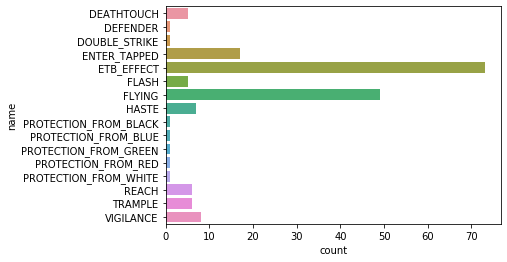

In [18]:
sns.barplot(x="count", y="name", data=pd_count, orient="h")

In [19]:
df_count_mult = df.select(["text_features_enc", "colorIdentity"]).\
                    groupBy(['text_features_enc', "colorIdentity"]).count().\
                    orderBy('text_features_enc', ascending=True)

In [20]:
df_count_mult = df_count_mult.withColumn('name', resolve_encoded_label('text_features_enc'))

In [21]:
pd_count_mult = df_count_mult.toPandas()

In [22]:
pd_count_mult

,text_features_enc,colorIdentity,count,name
0,0,B,2,DEATHTOUCH
1,0,"B,U",1,DEATHTOUCH
2,0,G,1,DEATHTOUCH
3,0,"B,G,U",1,DEATHTOUCH
4,1,U,1,DEFENDER
...,...,...,...,...
57,13,G,5,REACH
58,14,G,6,TRAMPLE
59,15,G,2,VIGILANCE
60,15,,1,VIGILANCE


## By color identity and text features

In [23]:
pivot = pd_count_mult.pivot("name", "colorIdentity", "count")

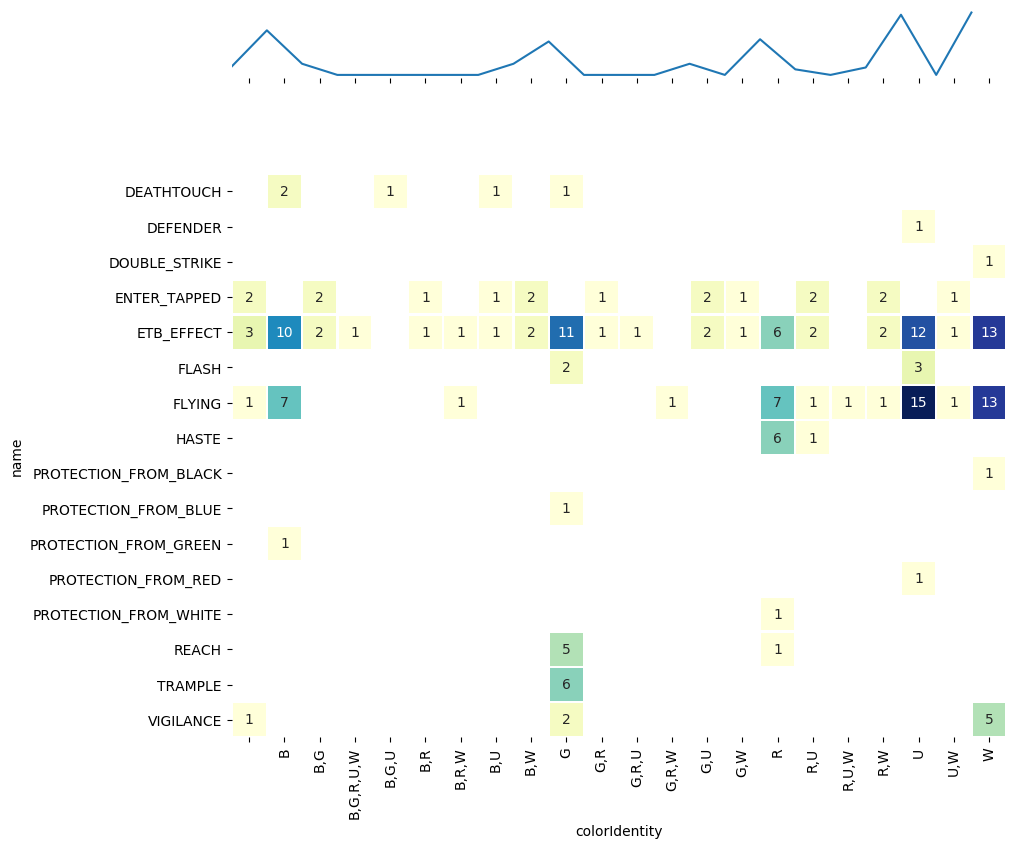

In [24]:
f, (ax_box, ax_hist) = plt.subplots(2, figsize=(10, 10), dpi=100, sharex=True, sharey=False, gridspec_kw={"height_ratios": (.10, .90)})
 
g = sns.lineplot(x="colorIdentity", y="count", data=pd_count_mult, ci=None, ax=ax_box)
# g = sns.countplot(x="colorIdentity", data=pd_count_mult, ax=ax_box)
sns.despine(top=True, bottom=True, left=True, right=True, offset=0.0)
ax_box.set(yticks=[])
ax_box.set(xticks=[])
ax_box.set(ylabel="")
ax_box.set(xlabel="")
ax_box.set(xlim=(-0.5, 23))
ax_box.set_xticklabels(range(0,23))

sns.heatmap(pivot, square=True, cmap="YlGnBu", cbar=False, linewidths=1.0, annot=True, ax=ax_hist)
